# Projeto de Sinais e Sistemas para Computação (SSC)

## II - Extração de Features de Sinais Digitais

Este notebook implementa diferentes métodos de extração de características de sinais:
- Características no domínio do tempo
- Características no domínio da frequência  
- O que mais precisarmos

In [ ]:
## 1. Importação de Bibliotecas

In [1]:
import numpy as np
import pandas as pd
from scipy import signal
from scipy.fft import fft, fftfreq
import wfdb
import matplotlib.pyplot as plt
import matplotlib
#matplotlib.use('Agg')
%matplotlib inline

import sys
import time as time_module
from datetime import datetime
import os
import json
import glob

import warnings
warnings.filterwarnings('ignore')

# Importar nosso módulo de pré-processamento
sys.path.append('../src')
from feature_extraction import (
    load_signal_processado, 
    extract_time_features, 
    extract_frequency_features,
    extract_shannon_entropy,
    pipeline,
    visualizar_features
)

# Configurações de visualização
plt.style.use('default')
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 10

## 1. Carregamento e Preparação dos Dados

Nesta seção carregamos os dados pré-processados do notebook anterior ou geramos sinais sintéticos para demonstração.

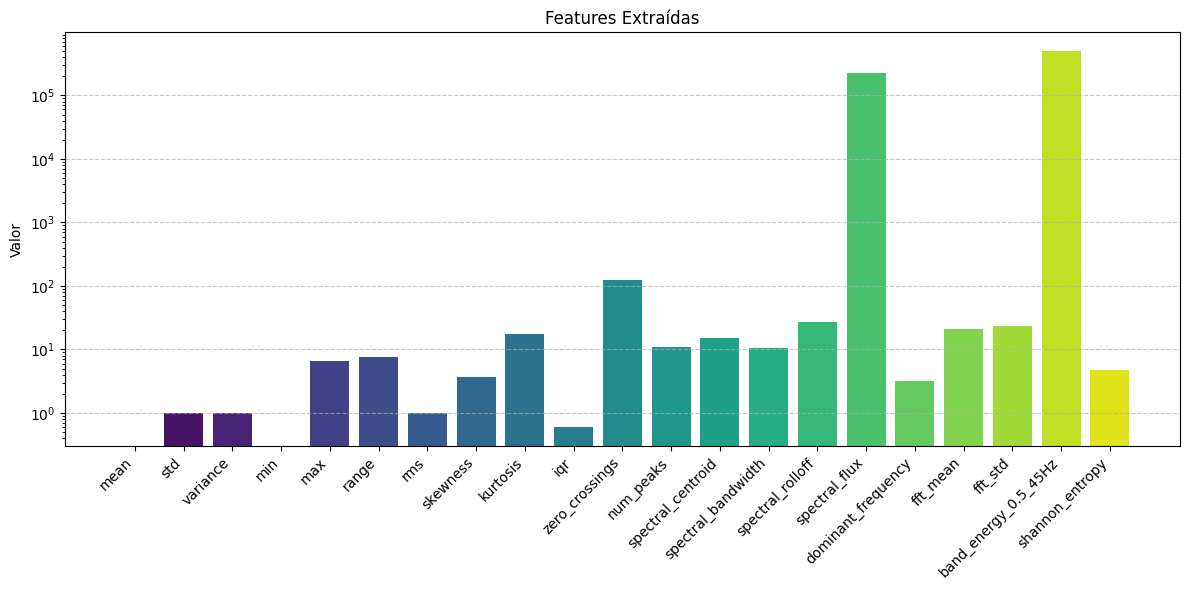

{'mean': -2.398081733190338e-17, 'std': 0.9999999999999999, 'variance': 0.9999999999999998, 'min': -1.1396397582981128, 'max': 6.481230315112511, 'range': 7.620870073410624, 'rms': 0.9999999999999999, 'skewness': 3.6696842039490822, 'kurtosis': 17.489251769017024, 'iqr': 0.5980759337591844, 'zero_crossings': 123, 'num_peaks': 11, 'spectral_centroid': 15.043631457128736, 'spectral_bandwidth': 10.679533558074972, 'spectral_rolloff': 27.3, 'spectral_flux': 227747.16149705675, 'dominant_frequency': 3.2, 'fft_mean': 20.850586242862875, 'fft_std': 23.77504913800532, 'band_energy_0.5_45Hz': 497350.9932110315, 'shannon_entropy': 4.816516012119572}



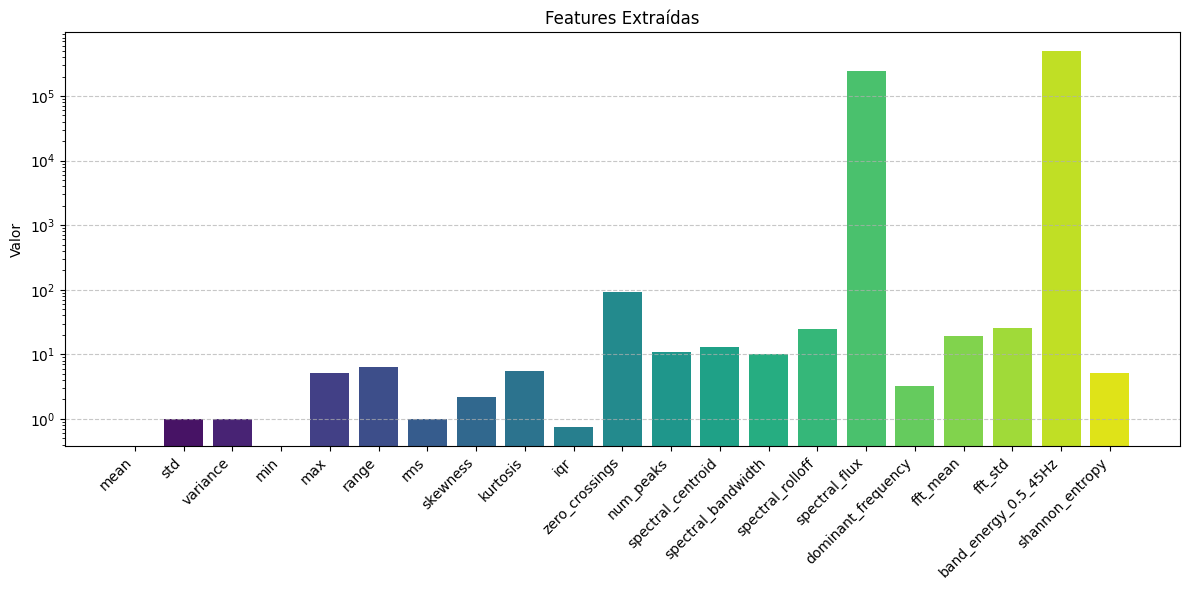

{'mean': 0.0, 'std': 1.0, 'variance': 1.0, 'min': -1.2210018654459092, 'max': 5.138141500405677, 'range': 6.359143365851586, 'rms': 1.0, 'skewness': 2.217192548286834, 'kurtosis': 5.6130683761893625, 'iqr': 0.7444203497726517, 'zero_crossings': 93, 'num_peaks': 11, 'spectral_centroid': 13.158576356068368, 'spectral_bandwidth': 10.248614302925846, 'spectral_rolloff': 24.400000000000002, 'spectral_flux': 245041.2542076853, 'dominant_frequency': 3.2, 'fft_mean': 18.95741220340676, 'fft_std': 25.31040341214899, 'band_energy_0.5_45Hz': 494565.64036672027, 'shannon_entropy': 5.174779362141696}



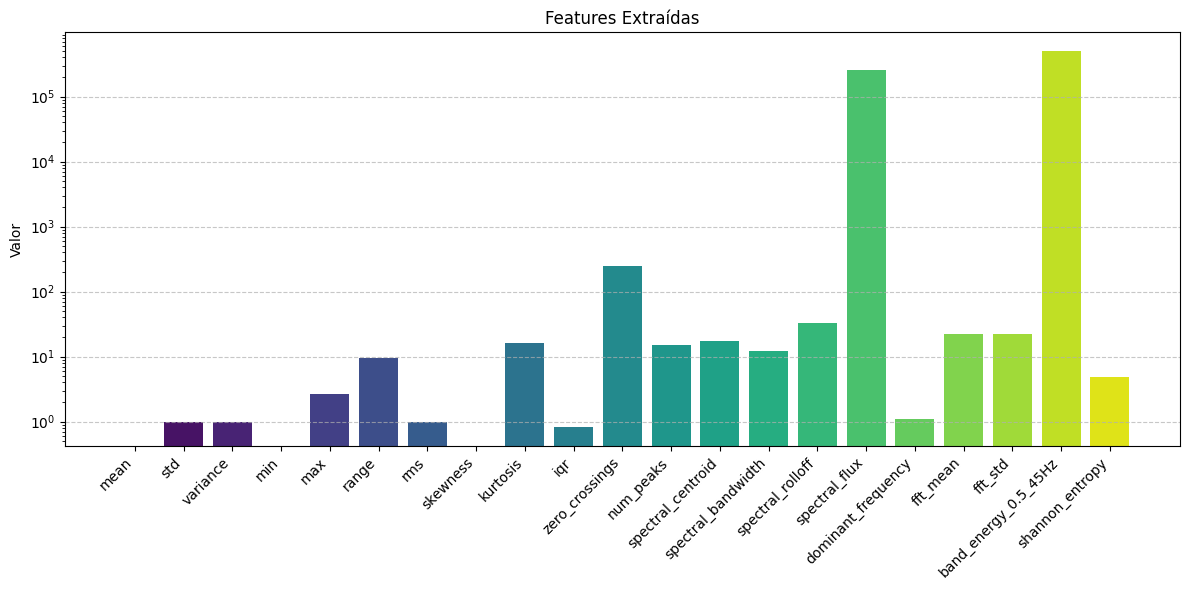

{'mean': 0.0, 'std': 1.0, 'variance': 1.0000000000000002, 'min': -6.990225948998113, 'max': 2.6387805744372046, 'range': 9.629006523435317, 'rms': 1.0, 'skewness': -3.0614638925753384, 'kurtosis': 16.17888151069268, 'iqr': 0.8205022809047453, 'zero_crossings': 251, 'num_peaks': 15, 'spectral_centroid': 17.600096984136744, 'spectral_bandwidth': 12.160942912372377, 'spectral_rolloff': 32.6, 'spectral_flux': 252933.89711195772, 'dominant_frequency': 1.1, 'fft_mean': 22.649231028474567, 'fft_std': 22.068346452503707, 'band_energy_0.5_45Hz': 499439.63918913354, 'shannon_entropy': 4.877444412688278}



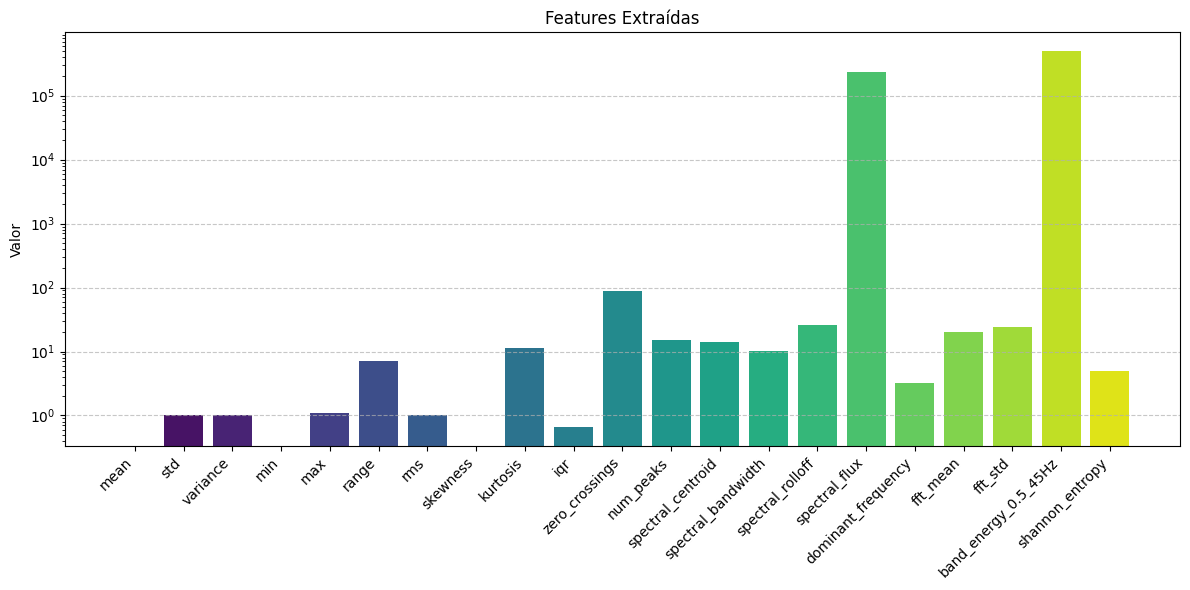

{'mean': -1.0658141036401503e-17, 'std': 1.0, 'variance': 1.0000000000000002, 'min': -5.915055594421217, 'max': 1.1037515705014231, 'range': 7.01880716492264, 'rms': 1.0, 'skewness': -2.9810154947161562, 'kurtosis': 11.466859552121528, 'iqr': 0.6564239429835743, 'zero_crossings': 87, 'num_peaks': 15, 'spectral_centroid': 14.092249539766332, 'spectral_bandwidth': 10.369859069346033, 'spectral_rolloff': 25.900000000000002, 'spectral_flux': 232283.06075199306, 'dominant_frequency': 3.2, 'fft_mean': 19.943367709465566, 'fft_std': 24.541027905073577, 'band_energy_0.5_45Hz': 496085.14874794934, 'shannon_entropy': 4.933418312155128}



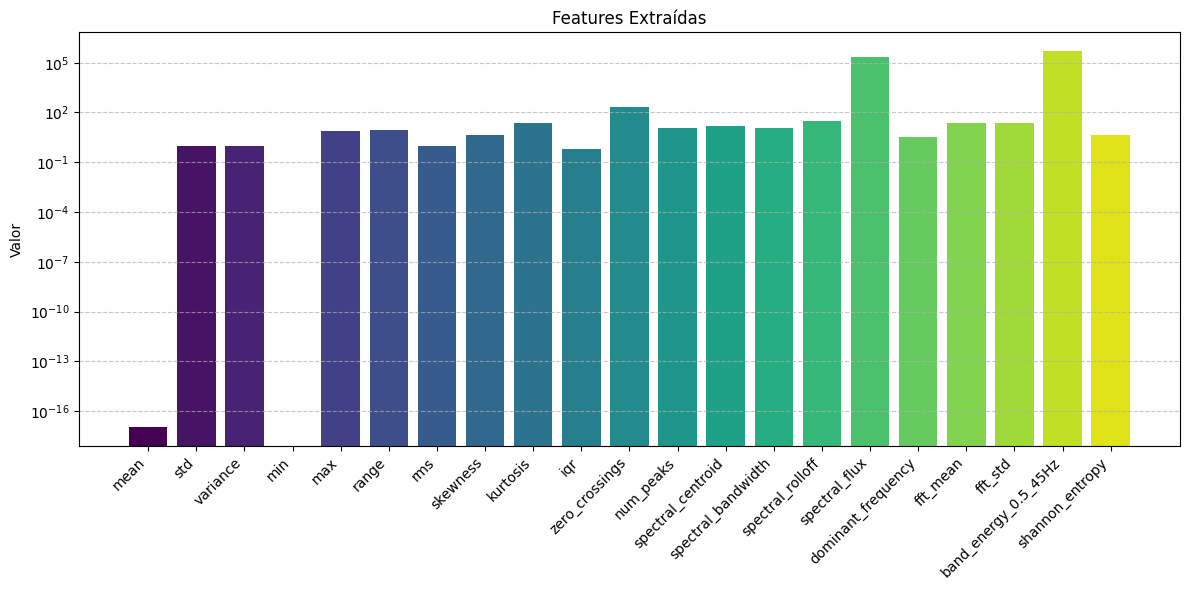

{'mean': 1.0658141036401503e-17, 'std': 0.9999999999999999, 'variance': 0.9999999999999999, 'min': -1.446419404997759, 'max': 7.189341548792248, 'range': 8.635760953790006, 'rms': 0.9999999999999999, 'skewness': 4.403656874193408, 'kurtosis': 24.500115059648202, 'iqr': 0.6218461000566599, 'zero_crossings': 211, 'num_peaks': 11, 'spectral_centroid': 16.26850126891824, 'spectral_bandwidth': 11.10057332948339, 'spectral_rolloff': 29.400000000000002, 'spectral_flux': 229403.9693456947, 'dominant_frequency': 3.2, 'fft_mean': 21.859318755670618, 'fft_std': 22.851039375508353, 'band_energy_0.5_45Hz': 498917.45843679324, 'shannon_entropy': 4.638995793618758}



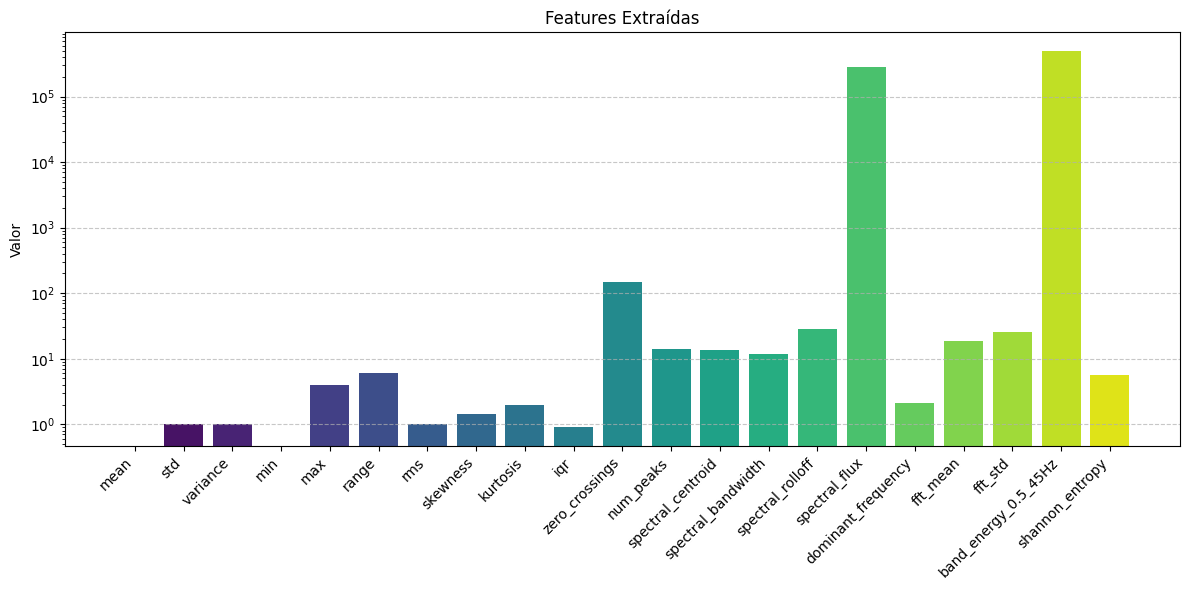

{'mean': -7.105427357601002e-18, 'std': 1.0, 'variance': 1.0000000000000002, 'min': -2.0102443232802725, 'max': 4.046881285495461, 'range': 6.057125608775733, 'rms': 1.0, 'skewness': 1.4541864739304222, 'kurtosis': 1.94032366948755, 'iqr': 0.9039863499890745, 'zero_crossings': 149, 'num_peaks': 14, 'spectral_centroid': 13.639277159864104, 'spectral_bandwidth': 11.842758528045461, 'spectral_rolloff': 28.8, 'spectral_flux': 285073.3340036936, 'dominant_frequency': 2.1, 'fft_mean': 18.389562223325168, 'fft_std': 25.725939140696056, 'band_energy_0.5_45Hz': 492740.599796875, 'shannon_entropy': 5.672684791420207}



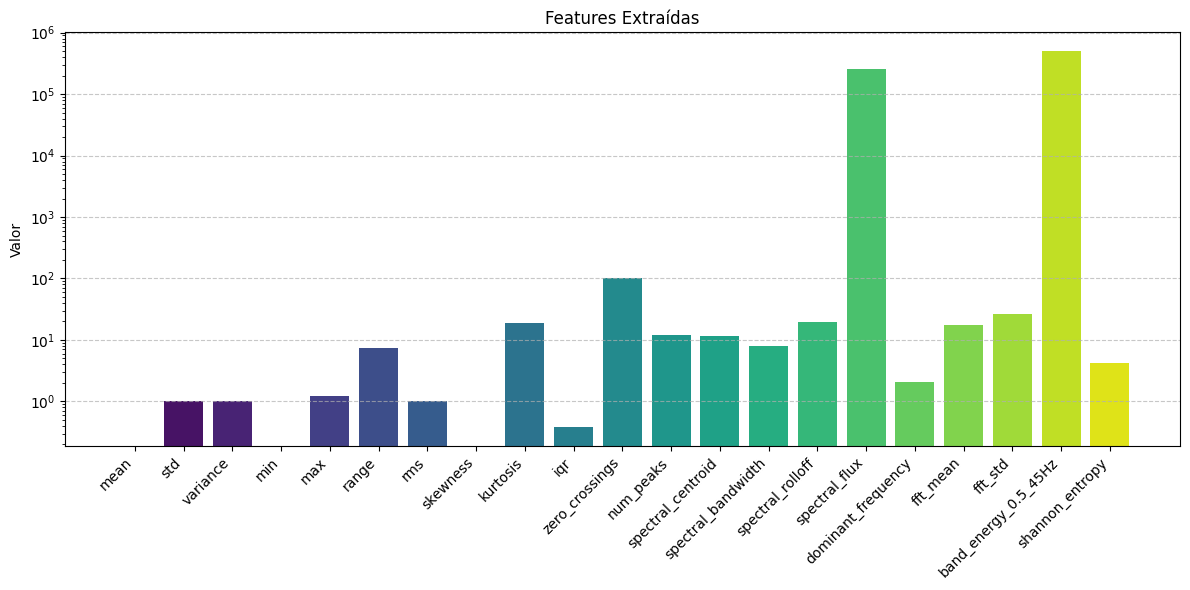

{'mean': 0.0, 'std': 0.9999999999999999, 'variance': 0.9999999999999998, 'min': -6.195736542203696, 'max': 1.2160746873209556, 'range': 7.411811229524652, 'rms': 0.9999999999999999, 'skewness': -4.156493022732718, 'kurtosis': 18.843865396075465, 'iqr': 0.3805174739409456, 'zero_crossings': 103, 'num_peaks': 12, 'spectral_centroid': 11.559509835851138, 'spectral_bandwidth': 8.062832100508473, 'spectral_rolloff': 19.5, 'spectral_flux': 256857.86129475632, 'dominant_frequency': 2.1, 'fft_mean': 17.361869161314637, 'fft_std': 26.43038866375973, 'band_energy_0.5_45Hz': 499988.3621710477, 'shannon_entropy': 4.253740743537596}



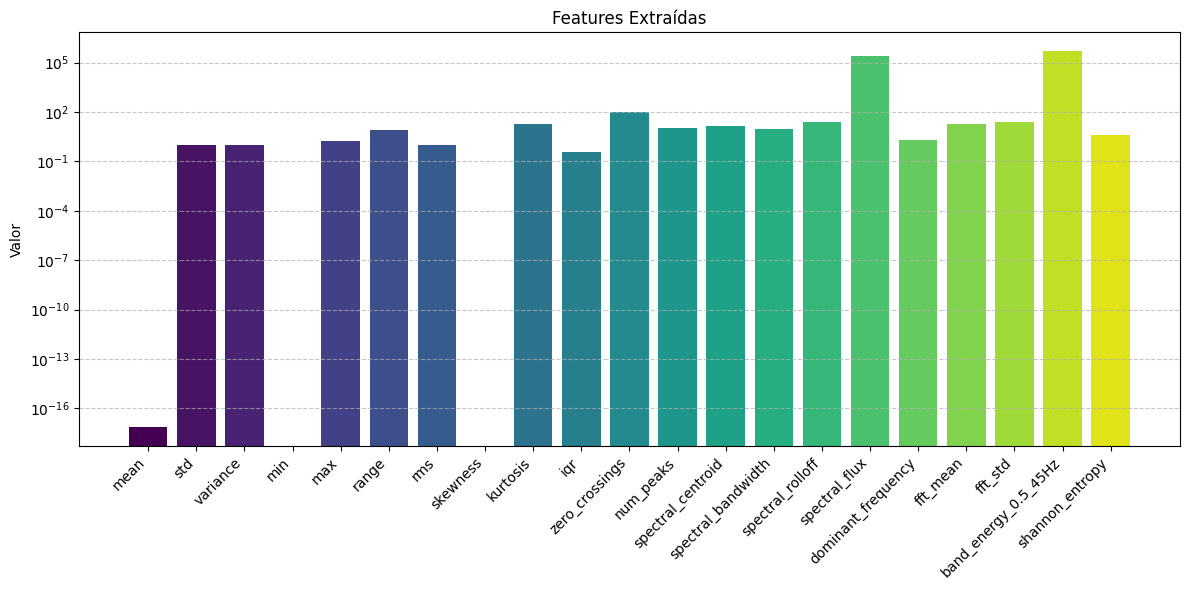

{'mean': 7.105427357601002e-18, 'std': 1.0, 'variance': 1.0000000000000002, 'min': -6.371782216527794, 'max': 1.8233209799012018, 'range': 8.195103196428995, 'rms': 1.0, 'skewness': -3.904357222984236, 'kurtosis': 19.977923683976307, 'iqr': 0.38458522127972516, 'zero_crossings': 99, 'num_peaks': 11, 'spectral_centroid': 13.945301303832352, 'spectral_bandwidth': 9.260170196779047, 'spectral_rolloff': 23.6, 'spectral_flux': 258534.96387581993, 'dominant_frequency': 2.1, 'fft_mean': 19.46370602365815, 'fft_std': 24.92316265271569, 'band_energy_0.5_45Hz': 499898.75277517556, 'shannon_entropy': 4.1622061302438755}



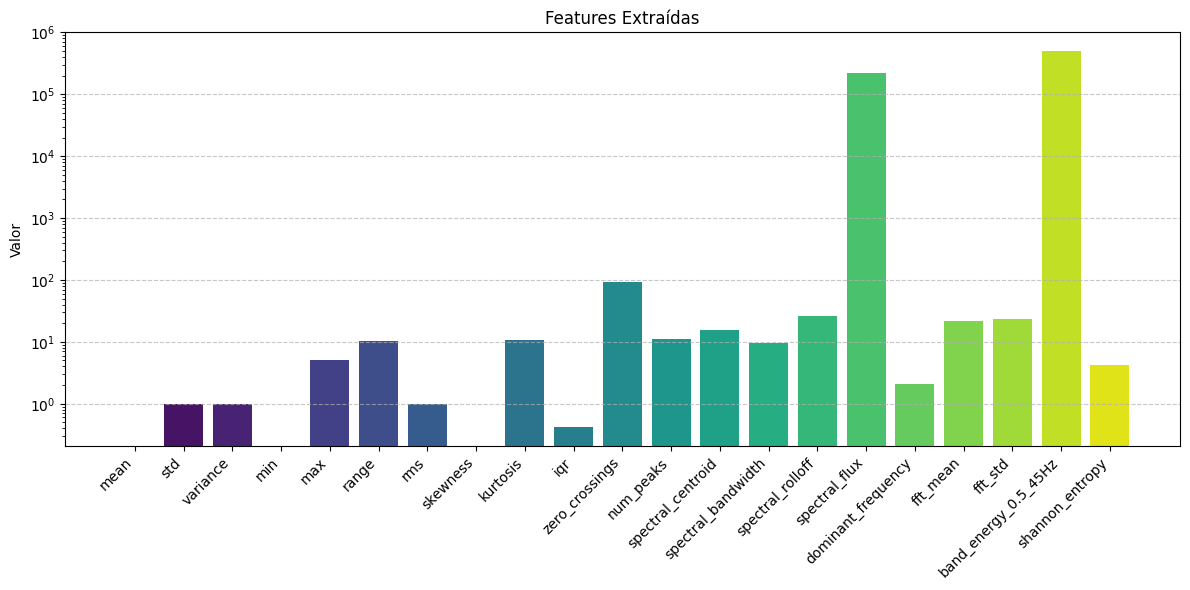

{'mean': 0.0, 'std': 0.9999999999999999, 'variance': 0.9999999999999999, 'min': -5.18982277341107, 'max': 5.150535318612417, 'range': 10.340358092023486, 'rms': 0.9999999999999999, 'skewness': -0.7663448843644407, 'kurtosis': 10.701616607578217, 'iqr': 0.41759172939554573, 'zero_crossings': 91, 'num_peaks': 11, 'spectral_centroid': 15.311814357128453, 'spectral_bandwidth': 9.547456567303273, 'spectral_rolloff': 25.8, 'spectral_flux': 223239.53617473604, 'dominant_frequency': 2.1, 'fft_mean': 21.375840215448445, 'fft_std': 23.30393642701527, 'band_energy_0.5_45Hz': 498294.7515765176, 'shannon_entropy': 4.16725736289789}



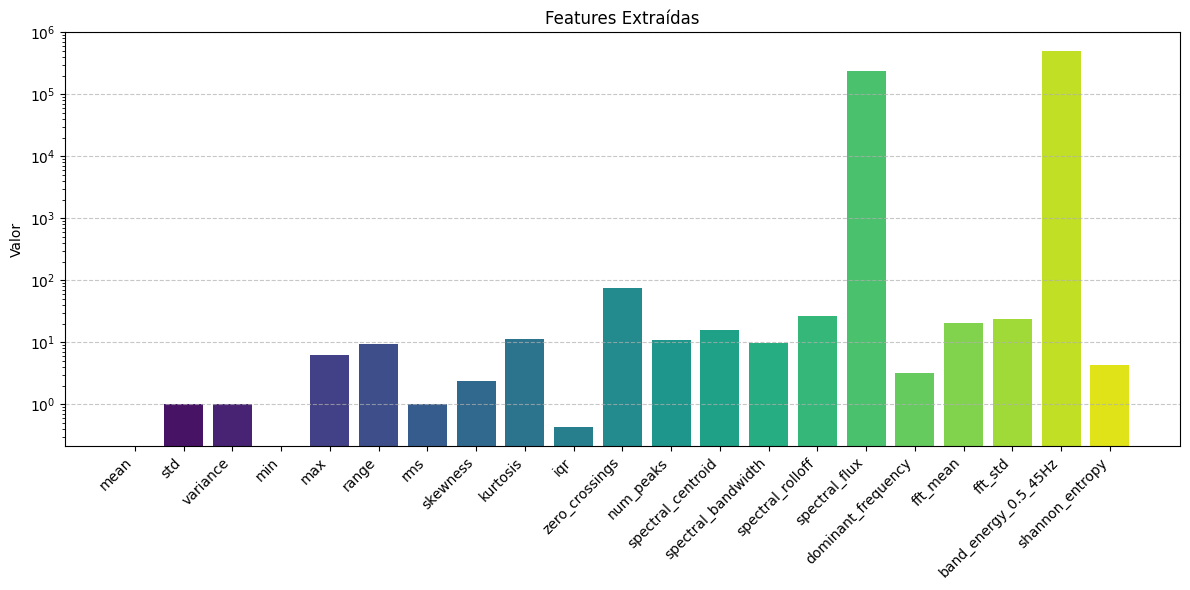

{'mean': -8.881784197001253e-19, 'std': 0.9999999999999999, 'variance': 0.9999999999999998, 'min': -3.188502720463594, 'max': 6.253914146936731, 'range': 9.442416867400325, 'rms': 0.9999999999999999, 'skewness': 2.34985415446813, 'kurtosis': 11.479415330789855, 'iqr': 0.43021831456001575, 'zero_crossings': 77, 'num_peaks': 11, 'spectral_centroid': 15.794683750481518, 'spectral_bandwidth': 9.792215065145044, 'spectral_rolloff': 26.3, 'spectral_flux': 239742.35250803275, 'dominant_frequency': 3.2, 'fft_mean': 20.83078268936, 'fft_std': 23.792385970589113, 'band_energy_0.5_45Hz': 499761.57942051, 'shannon_entropy': 4.321833222033448}



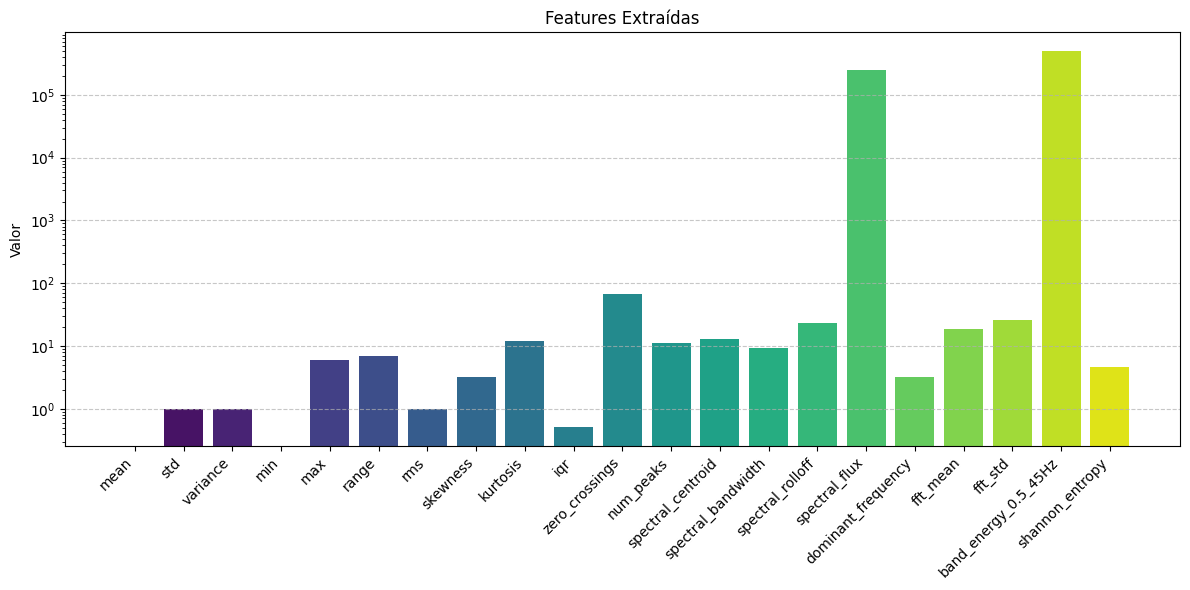

{'mean': -5.3290705182007515e-18, 'std': 0.9999999999999999, 'variance': 0.9999999999999998, 'min': -1.0815345439443464, 'max': 5.900012991045328, 'range': 6.981547534989675, 'rms': 0.9999999999999999, 'skewness': 3.1805350147394624, 'kurtosis': 12.117159526991319, 'iqr': 0.5089427380875214, 'zero_crossings': 67, 'num_peaks': 11, 'spectral_centroid': 13.077265394383463, 'spectral_bandwidth': 9.411445939136899, 'spectral_rolloff': 23.1, 'spectral_flux': 250276.56039175225, 'dominant_frequency': 3.2, 'fft_mean': 18.602592748151988, 'fft_std': 25.57231849063631, 'band_energy_0.5_45Hz': 497136.8936070415, 'shannon_entropy': 4.6209703238253566}



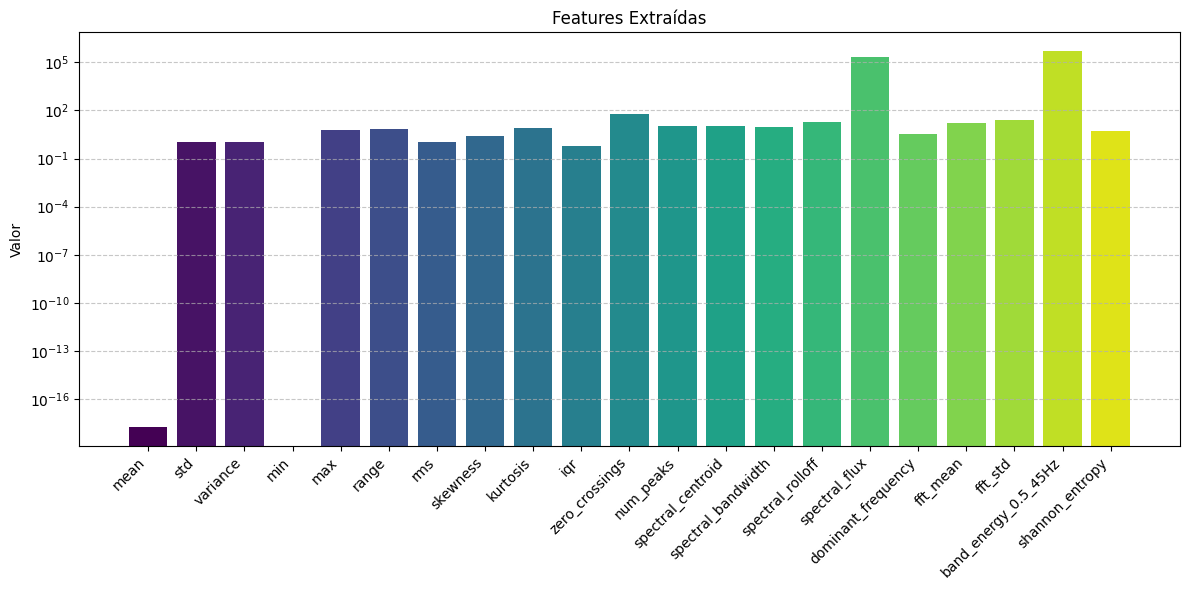

{'mean': 1.7763568394002505e-18, 'std': 1.0, 'variance': 1.0000000000000002, 'min': -1.3197922708208594, 'max': 5.8730487533099325, 'range': 7.192841024130792, 'rms': 1.0, 'skewness': 2.5609514376401954, 'kurtosis': 7.498787500280498, 'iqr': 0.6177502356209631, 'zero_crossings': 61, 'num_peaks': 11, 'spectral_centroid': 10.480309692159288, 'spectral_bandwidth': 8.648064238277142, 'spectral_rolloff': 19.1, 'spectral_flux': 222775.9681018638, 'dominant_frequency': 3.2, 'fft_mean': 16.828332743185168, 'fft_std': 26.773255050547956, 'band_energy_0.5_45Hz': 493765.08498444833, 'shannon_entropy': 4.881798221589546}



In [2]:
arquivo_npz = "../data/processed/records000/00001_processed.npz"

signals, metadata = load_signal_processado(arquivo_npz)
fs = metadata.get('fs', 100)

if len(signals.shape) == 2:
    for i in range(0, 12):
        features = pipeline(signals, i, fs)
        visualizar_features(features)
        print(f"{features}\n")

## 2. Extração de Características no Domínio do Tempo

As características temporais capturam propriedades estatísticas e morfológicas do sinal ao longo do tempo.

## 3. Extração de Características no Domínio da Frequência

As características espectrais revelam a composição frequencial dos sinais através da análise de Fourier.

## 4. Criação do Dataset de Características

Combinamos todas as características extraídas em um DataFrame estruturado para análise e classificação.

## 5. Visualização e Análise das Características

Análise exploratória das características extraídas para entender a separabilidade entre classes.

## 6. Resumo

### ✅ Características Implementadas:

#### **Domínio do Tempo (tudo que pensei coloquei aqui, dps arrumar):**
- Estatísticas básicas: média, mediana, desvio padrão, variância
- Características de forma: assimetria, curtose, RMS, energia
- Análise de cruzamentos: zero crossings, taxa de cruzamento
- Variabilidade: coeficiente de variação, variação média
- Percentis: Q1, Q3, IQR

#### **Domínio da Frequência (mesm coisa):**
- 

### 📊 **Dataset Final:**
- **Total**: 
- **Amostras**: 
- **Categorias**: 
- **Formato**: CSV salvo em `../data/processed/features_dataset.csv` - exemplo

---
**🚀 Dataset de características pronto para a etapa de classificação!**